In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

data = yf.download("EMR", start="2010-01-01", end="2019-04-30")

[*********************100%***********************]  1 of 1 downloaded


In [34]:
data.index[1000]

Timestamp('2013-12-20 00:00:00')

Stock prices values are stated in terms of it's 'closing price' and it's 'adjusted closing price'. The closing price is the 'raw' price which is just the cash value of the last transacted price before the market closes. The adjusted closing price factors in anything that might affect the stock price after the market closes.

In [3]:
adjdata=data[:1000]
adjdata=adjdata[['Adj Close']]

In [4]:
adjdata

,Adj Close
Date,
2009-12-31,31.38
2010-01-04,31.94
2010-01-05,31.99
2010-01-06,32.28
2010-01-07,32.28
...,...
2013-12-13,54.63
2013-12-16,55.20
2013-12-17,54.84


C:\Users\GLORI\Desktop\FYP\env\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


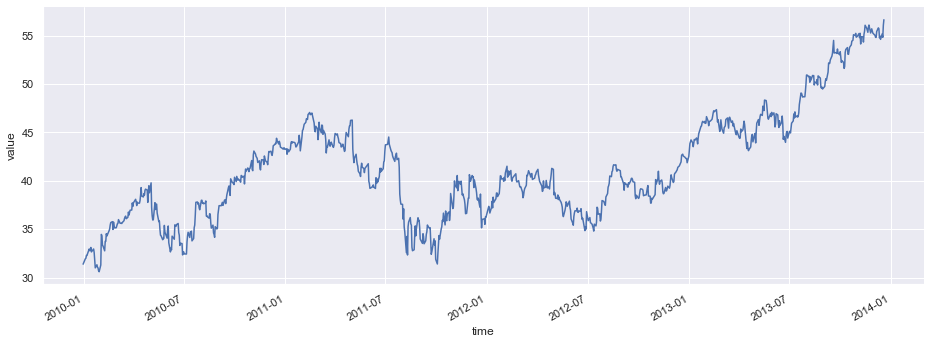

In [5]:
plotdata=pd.DataFrame(dict(time=adjdata.index,
                       value=adjdata['Adj Close']))
g = sns.relplot(x='time', y='value', kind="line", data=plotdata)
g.fig.set_size_inches(15, 5)
g.fig.autofmt_xdate()

np.diff() calculate the difference between current value and previous one

In [6]:
adjdata['delta'] = np.append(np.array([0]),
                        np.diff(adjdata['Adj Close'].values))
adjdata['delta'].head()

Date
2009-12-31    0.00
2010-01-04    0.56
2010-01-05    0.05
2010-01-06    0.29
2010-01-07    0.00
Name: delta, dtype: float64

In [7]:
adjdata

,Adj Close,delta
Date,,
2009-12-31,31.38,0.00
2010-01-04,31.94,0.56
2010-01-05,31.99,0.05
2010-01-06,32.28,0.29
2010-01-07,32.28,0.00
...,...,...
2013-12-13,54.63,-0.34
2013-12-16,55.20,0.57
2013-12-17,54.84,-0.36


A[0] contains the zero-frequency term (the sum of the signal), which is always purely real for real inputs. Then A[1:n/2] contains the positive-frequency terms, and A[n/2+1:] contains the negative-frequency terms, in order of decreasingly negative frequency. 

In [8]:
sp = np.fft.fft(adjdata['delta'].values)

In [9]:
adjdata['theta'] = np.arctan(sp.imag/sp.real)
numValues = len(adjdata)
numValuesHalf = numValues / 2
adjdata['amplitude'] = np.sqrt(sp.real**2 + sp.imag**2)/numValuesHalf
adjdata['freq'] = np.fft.fftfreq(sp.size, d=1)
adjdata.head()

,Adj Close,delta,theta,amplitude,freq
Date,,,,,
2009-12-31,31.38,0.00,0.000000,0.050560,0.000
2010-01-04,31.94,0.56,0.413740,0.042878,0.001
2010-01-05,31.99,0.05,1.469673,0.010573,0.002
2010-01-06,32.28,0.29,-0.778418,0.021602,0.003
2010-01-07,32.28,0.00,0.657970,0.054207,0.004


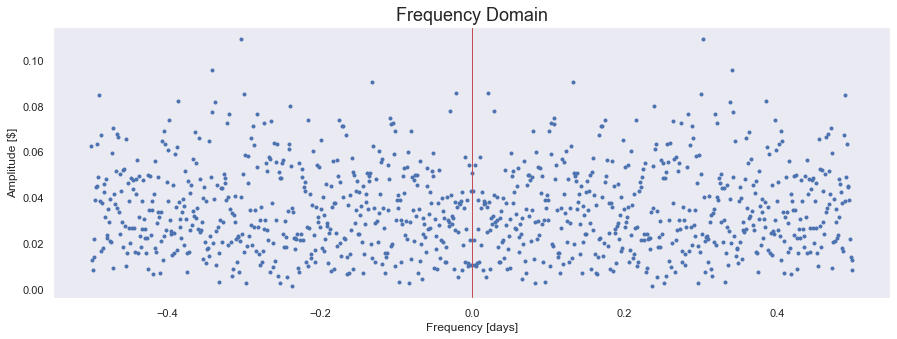

In [10]:
plt.figure(figsize=(15,5))
plt.plot(adjdata['freq'],adjdata['amplitude'].values, '.')
plt.axvline(x=0, ymin=0, ymax = 1, linewidth=1, color='r')
plt.ylabel('Amplitude [$]', fontsize=12)
plt.xlabel('Frequency [days]', fontsize=12)
plt.title('Frequency Domain', fontsize=18)
plt.grid()

In [22]:
stdAmp = adjdata['amplitude'].std()
print(stdAmp)

0.01885015853682621


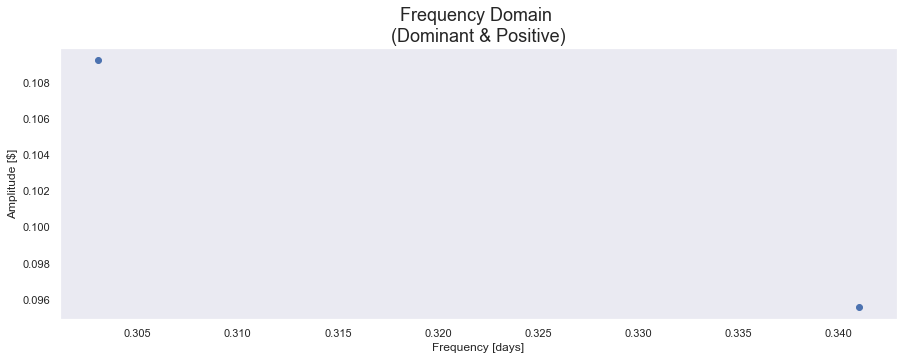

In [11]:
meanAmp = adjdata['amplitude'].mean()
stdAmp = adjdata['amplitude'].std()
dominantAmpCheck = adjdata['amplitude'] > (3*stdAmp + meanAmp) 
positiveFreqCheck = adjdata['freq'] > 0
dominantAmp = adjdata[dominantAmpCheck & positiveFreqCheck]['amplitude']
dominantFreq = adjdata[dominantAmpCheck & positiveFreqCheck]['freq']
dominantTheta = adjdata[dominantAmpCheck & positiveFreqCheck]['theta']

plt.figure(figsize=(15,5))
plt.plot(dominantFreq, dominantAmp, 'o')
plt.ylabel('Amplitude [$]', fontsize=12)
plt.xlabel('Frequency [days]', fontsize=12)
plt.title('Frequency Domain \n(Dominant & Positive)', fontsize=18)
plt.grid();

In [12]:
regressionDelta = 0

for n in range(len(dominantTheta)):
    shift = dominantTheta[n]
    regressionDelta += dominantAmp[n] * np.cos(n * np.array(range(len(adjdata))) + shift)


#Converting Delta Time to Time at start value of real data    
startValue = adjdata['Adj Close'][0]
regression = startValue + np.cumsum(regressionDelta)

In [13]:
adjdata['regression']=regression

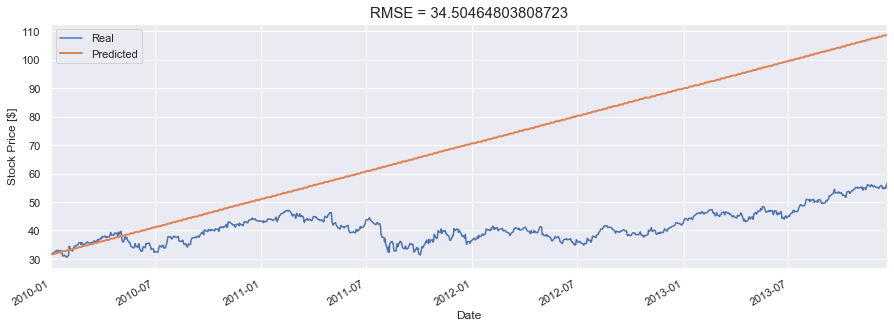

In [14]:
plt.figure(figsize=(15,5))
adjdata['Adj Close'].plot(grid=True)
plt.plot(adjdata['regression'],linewidth=2)

plt.ylabel('Stock Price [$]')
plt.legend(['Real','Predicted']);

rmse = np.sqrt(np.mean((adjdata['Adj Close'].values - regression)**2))

plt.title('RMSE = ' + str(rmse), fontsize=15);

In [15]:
def std_filter(std_value):
    
    #Getting dominant values based on std_value
    meanAmp = adjdata['amplitude'].mean()
    stdAmp = adjdata['amplitude'].std()
    dominantAmpCheck = adjdata['amplitude'] > (std_value*stdAmp + meanAmp) 
    positiveFreqCheck = adjdata['freq'] > 0
    dominantAmp = adjdata[dominantAmpCheck & positiveFreqCheck]['amplitude']
    dominantFreq = adjdata[dominantAmpCheck & positiveFreqCheck]['freq']
    dominantTheta = adjdata[dominantAmpCheck & positiveFreqCheck]['theta']
    
    #Calculating Regression Delta
    regressionDelta = 0
    for n in range(len(dominantTheta)):
        shift = dominantTheta[n]
        regressionDelta += dominantAmp[n] * np.cos(n * np.array(range(len(adjdata))) + shift)

    #Converting Delta Time to Time at start value of real data    
    startValue = adjdata['Adj Close'][0]
    regression = startValue + np.cumsum(regressionDelta)
    
    #Calculating RMSE
    rmse = np.sqrt(np.mean((adjdata['Adj Close'].values - regression)**2))
    
    if np.isnan(rmse):
        rmse = 10000000000000
    
    return rmse

In [28]:
std_values = []
rmse_values = []

for i in np.linspace(0,3,20):
    std_values.append(i)
    rmse_values.append(std_filter(i))

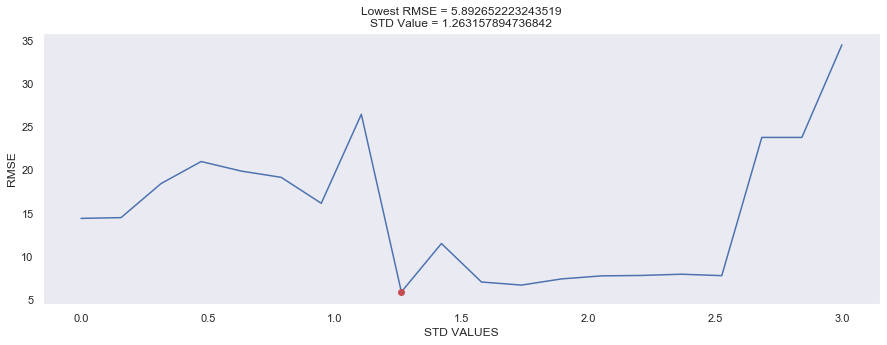

In [29]:
idx = np.array(rmse_values).argmin()
minSTD = std_values[idx]
minRMSE = rmse_values[idx]

plt.figure(figsize=(15,5))
plt.plot(std_values, rmse_values)
plt.plot(minSTD, minRMSE, 'ro')
plt.ylabel('RMSE')
plt.xlabel('STD VALUES')
plt.title('Lowest RMSE = '+str(minRMSE)+'\nSTD Value = '+str(minSTD))
plt.grid()

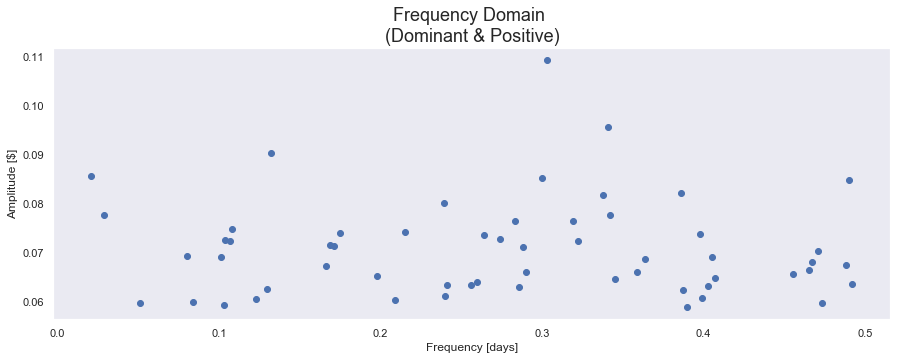

In [30]:
meanAmp = adjdata['amplitude'].mean()
stdAmp = adjdata['amplitude'].std()
dominantAmpCheck = adjdata['amplitude'] > (minSTD*stdAmp + meanAmp) 
positiveFreqCheck = adjdata['freq'] > 0
dominantAmp = adjdata[dominantAmpCheck & positiveFreqCheck]['amplitude']
dominantFreq = adjdata[dominantAmpCheck & positiveFreqCheck]['freq']
dominantTheta = adjdata[dominantAmpCheck & positiveFreqCheck]['theta']

plt.figure(figsize=(15,5))
plt.plot(dominantFreq, dominantAmp, 'o')
plt.ylabel('Amplitude [$]', fontsize=12)
plt.xlabel('Frequency [days]', fontsize=12)
plt.title('Frequency Domain \n(Dominant & Positive)', fontsize=18)
plt.grid();

Text(0.5, 1.0, 'RMSE = 5.892652223243519')

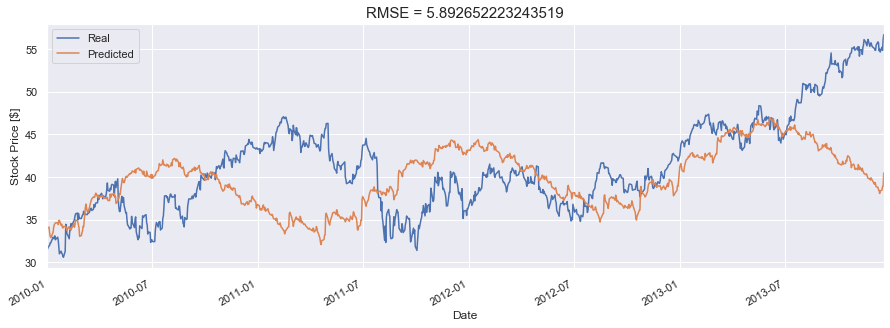

In [31]:
#Getting dominant values based on std_value
meanAmp = adjdata['amplitude'].mean()
stdAmp = adjdata['amplitude'].std()
dominantAmpCheck = adjdata['amplitude'] > (minSTD*stdAmp + meanAmp) 
positiveFreqCheck = adjdata['freq'] > 0
dominantAmp = adjdata[dominantAmpCheck & positiveFreqCheck]['amplitude']
dominantFreq = adjdata[dominantAmpCheck & positiveFreqCheck]['freq']
dominantTheta = adjdata[dominantAmpCheck & positiveFreqCheck]['theta']

#Calculating Regression Delta
regressionDelta = 0
for n in range(len(dominantTheta)):
    shift = dominantTheta[n]
    regressionDelta += dominantAmp[n] * np.cos(n * np.array(range(len(adjdata))) + shift)

#Converting Delta Time to Time at start value of real data    
startValue = adjdata['Adj Close'][0]
regression = startValue + np.cumsum(regressionDelta)
adjdata['regression']=regression
plt.figure(figsize=(15,5))
adjdata['Adj Close'].plot(grid=True)
plt.plot(adjdata['regression'])
plt.ylabel('Stock Price [$]')
plt.legend(['Real','Predicted']);

rmse = np.sqrt(np.mean((adjdata['Adj Close'].values - regression)**2))

plt.title('RMSE = ' + str(rmse), fontsize=15)

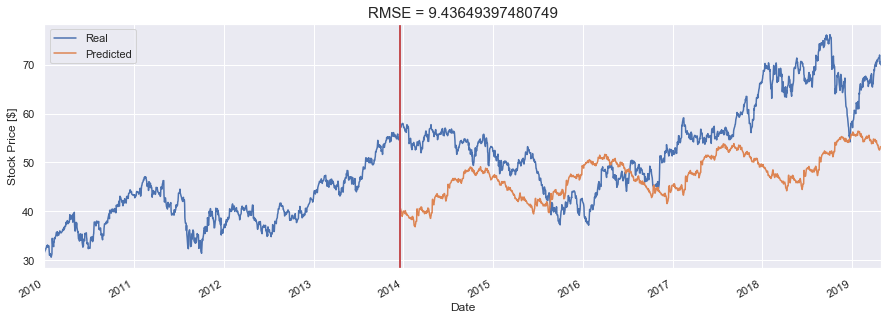

In [36]:
#Calculating Regression Delta
regressionDelta = 0
for n in range(len(dominantTheta)):
    shift = dominantTheta[n]
    regressionDelta += dominantAmp[n] * np.cos(n * np.array(range(len(data))) + shift)

#Converting Delta Time to Time at start value of real data    
startValue = adjdata['Adj Close'][0]
regression = startValue + np.cumsum(regressionDelta)

data['regression']=regression
plt.figure(figsize=(15,5))
data['Adj Close'].plot(grid=True)
plt.plot(data['regression'][1000:])
plt.ylabel('Stock Price [$]')
plt.legend(['Real','Predicted'])

plt.axvline(x='2013-12-20', ymin=0, ymax = 1, linewidth=2, color='r')

rmse = np.sqrt(np.mean((data['Adj Close'].values - regression)**2))

plt.title('RMSE = ' + str(rmse), fontsize=15);

In [1]:
"hi"

'hi'